<b>COSMIC RADIATION: Random forest</b>
    
rodrigoX: Contains 4 parameters
    1. NALLParticlesTotal : Total number of particles generated by the event in the ground level.
    2. MUTotal : Total number of muons.
    3. ELTotal : Total number of electromagnetic particles.
    4. Zenith : Zenith angle of the particle [degrees].
    5. Energy : Particle energy [GeV].

rodrigoY: contains the target
    Labels: photon, proton, helium, nitrogen, iron.
        the smallest number is assigned to photon (A=0) and the highest number to the heaviest particle, this is, iron (B=4).
        
        0==photon     1==proton    2==helium     3==nitrogen   4==iron 
     
     

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

### data

In [21]:
#leave the dataset ready
df_x = pd.read_fwf('XRodrigo.txt')
df_x.columns = ["NALLParticlesTotal", "MUTotal", "ELTotal", "Zenith","Energy"]
df_y=pd.read_fwf('YRodrigo.txt')
df_y.columns = ["Particle"]

transpose=df_x.T
transpose_y=df_y.T #Transpose to put them together
df_tot = transpose.append(transpose_y)
df_tot=df_tot.T.sample(frac=1).reset_index(drop=True)#este el el df completo y barajado

df_y=df_tot[['Particle']]
df_x=df_tot[["NALLParticlesTotal", "MUTotal", "ELTotal", "Zenith","Energy"]]

In [22]:
#train-test split and reescale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, random_state=0,test_size = 0.25)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_test_np=y_test.to_numpy()
y_train_np=y_train.to_numpy().flatten()


### grid search

In [10]:
# Number of trees in random forest
n_estimators = [1000]#[100,500,1000]
# Number of features to consider at every split
max_features = [3]#[2,3,4,5]
# Maximum number of levels in tree
max_depth = [19]

bootstrap = [False]
# Create the random grid
parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
grid = GridSearchCV(RandomForestRegressor(), parameters,  n_jobs=-1,cv=5, verbose=1 )

grid_result=clf.fit(X_train, y_train)

In [14]:
print(grid_result)
print("The best parameters are %s with a score of %0.5f"
      % (grid_result.best_params_, grid_result.best_score_))
results = pd.DataFrame(grid.cv_results_)
results.to_csv('grid-search-results-01.csv', index=False)


C:\Users\HP\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=58,
                                             max_features=3,
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=1000, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1

### model

In [23]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000,max_depth=19,max_features=3,random_state = 42)
# Train the model on training data
rf=rf.fit(X_train, y_train);

In [137]:
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[1705    0    0    0    0]
 [   0 1626   24    2    0]
 [   0   15 1588   80    0]
 [   0    1   70 1596    9]
 [   0    0    9   40 1634]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1705
         1.0       0.99      0.98      0.99      1652
         2.0       0.94      0.94      0.94      1683
         3.0       0.93      0.95      0.94      1676
         4.0       0.99      0.97      0.98      1683

    accuracy                           0.97      8399
   macro avg       0.97      0.97      0.97      8399
weighted avg       0.97      0.97      0.97      8399

0.9702345517323491


In [139]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: MUTotal              Importance: 0.37
Variable: ELTotal              Importance: 0.33
Variable: NALLParticlesTotal   Importance: 0.17
Variable: Energy               Importance: 0.12
Variable: Zenith               Importance: 0.0


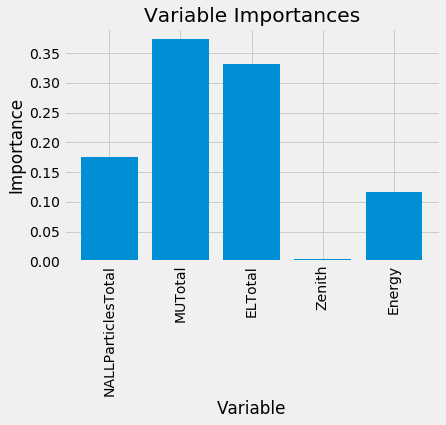

In [140]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [95]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = ["NALLParticlesTotal", "MUTotal", "ELTotal", "Zenith","Energy"], rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [96]:
feature_list=["NALLParticlesTotal", "MUTotal", "ELTotal", "Zenith","Energy"]
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [99]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
